In [148]:
from spectral_cube import SpectralCube
from spectral_cube import Projection
#from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import constants as const
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
from cycler import cycler
from itertools import cycle
from scipy.optimize import fsolve
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

In [2]:
m = 2e4 * u.Msun
v = 20 * u.km / u.second
(m*v**2).to(u.erg)

<Quantity 1.5907279e+50 erg>

In [3]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')


In [4]:
combo_fixednames = [
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.12CO.spw17.fits',
    'lol',
    #'/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.CH3OH.masked.spw21.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw23.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.H2CO.spw25.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.SiO.spw27.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.13CO.spw29.fits',
    '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/galcorrected/g5.C18O.spw31.fits'
    ]

cube_17 = SpectralCube.read(combo_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
#cube21 = SpectralCube.read(combo_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
#cube23 = SpectralCube.read(combo_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
#cube25 = SpectralCube.read(combo_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
#cube27 = SpectralCube.read(combo_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_29 = SpectralCube.read(combo_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')
cube_31 = SpectralCube.read(combo_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')

In [5]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).mad_std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def ratio_formal(mom0_numer, mom0_denom, mask_numer):
    ratio = mom0_numer / (mom0_denom).reproject(header=mom0_numer.header)
    ratio = ratio*mask_numer
    # Ratio must be reasonable
    try: 
        ratio[ratio > 5] = np.nan
    except: 
        ratio[ratio > 5*u.K] = np.nan
    ratio.quicklook(use_aplpy=False)
    return ratio

def mean_ratio(ratio):
    return np.nanmean(ratio, axis=0)
    #return np.nanmedian(ratio, axis=0)

## Total Cubes

In [6]:
mom0_17 = cube_17.with_mask(cube_17>0.05*u.K).spectral_slab(15*u.km/u.s, 200*u.km/u.s).moment0()
mom0_29 = cube_29.with_mask(cube_29>0.05*u.K).spectral_slab(15*u.km/u.s, 200*u.km/u.s).moment0()
mom0_31 = cube_31.spectral_slab(15*u.km/u.s, 200*u.km/u.s).moment0()

cube_17.allow_huge_operations=True

spatialmask17 = cube_17.with_mask(cube_17>0.05*u.K)#noise_mask(cube_17.with_mask(cube_17>0.05*u.K), 15*u.km / u.second, 200*u.km/u.second, 5.0)
spatialmask29 = cube_29.with_mask(cube_29>0.05*u.K)#noise_mask(cube_29.with_mask(cube_29>0.05*u.K), 15*u.km / u.second, 200*u.km/u.second, 5.0)
spatialmask31 = cube_31.with_mask(cube_31>0.05*u.K)#noise_mask(cube_31.with_mask(cube_31>0.05*u.K), 15*u.km / u.second, 200*u.km/u.second, 5.0)

## 12CO

In [7]:
# A is the high velocity cloud from 75 to 200 km/s
cube17a = cube_17.with_mask(cube_17>0.05*u.K).spectral_slab(75*u.km/u.s, 200*u.km/u.s)
# B is the low velocity cloud from 15 to 75 km/s
cube17b = cube_17.with_mask(cube_17>0.05*u.K).spectral_slab(15*u.km/u.s, 75*u.km/u.s)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


INFO: Auto-setting vmin to -5.800e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.698e+00 [aplpy.core]


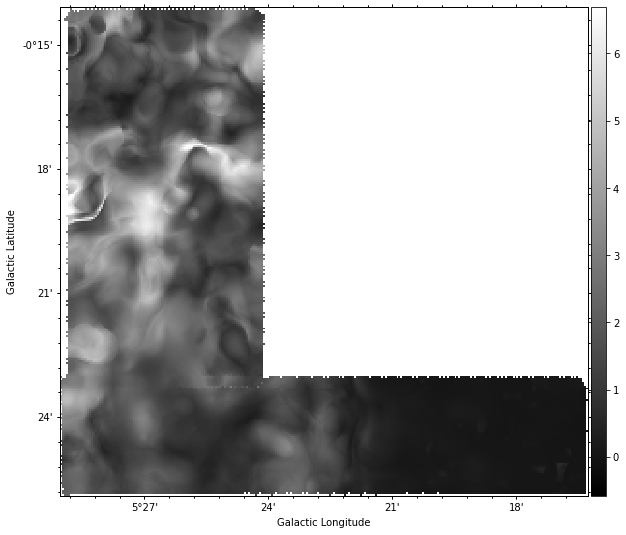

In [8]:
noise = cube17a.mad_std(axis=0)
noise.quicklook()

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


INFO: Auto-setting vmin to -5.702e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.764e+00 [aplpy.core]


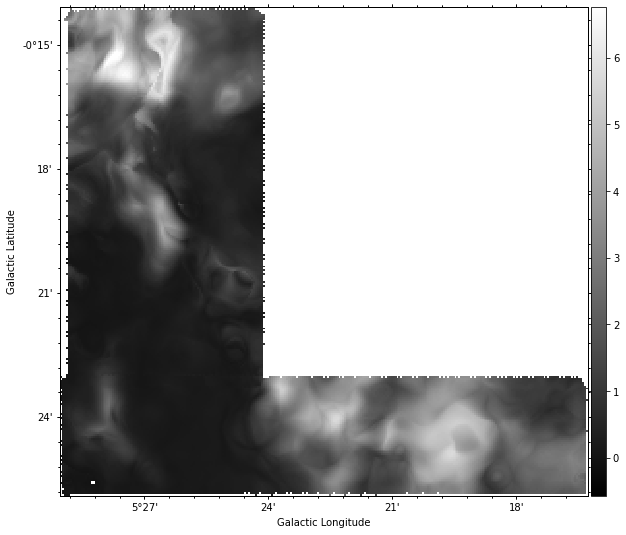

In [9]:
noise = cube17b.mad_std(axis=0)
noise.quicklook()

(0.0, 1.0)

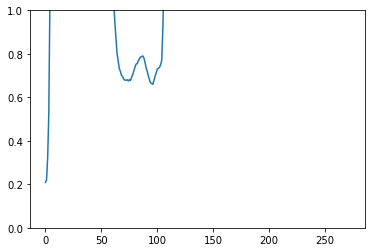

In [10]:
plt.plot(np.nanmean(noise,axis=0))
plt.ylim(0, 1)

INFO: Auto-setting vmin to -6.174e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.140e+02 [aplpy.core]


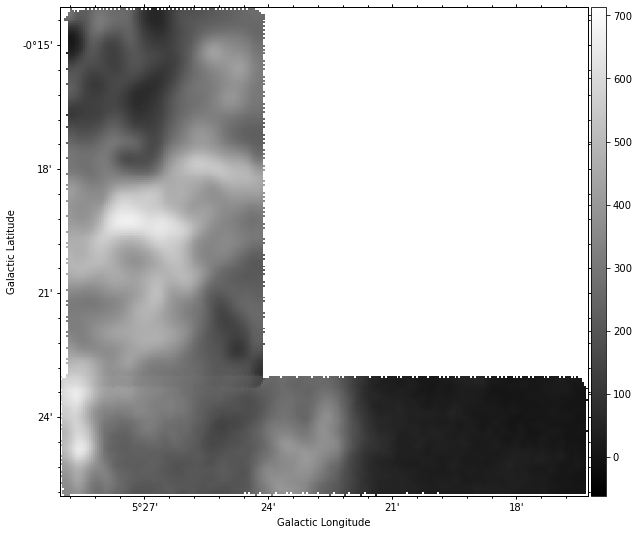

In [11]:
cube17a.moment0().quicklook()

In [12]:
mask17a = cube17a > 0.1 * u.K
mask17a

INFO: Auto-setting vmin to -6.317e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.096e+02 [aplpy.core]


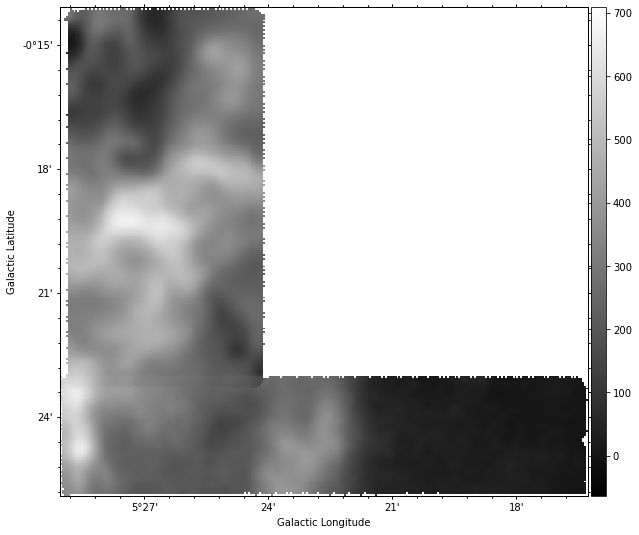

In [13]:
mom0_17a = cube17a.with_mask(mask17a).moment0()
(cube17a.with_mask(mask17a)).moment0().quicklook()

INFO: Auto-setting vmin to -4.040e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.533e+02 [aplpy.core]


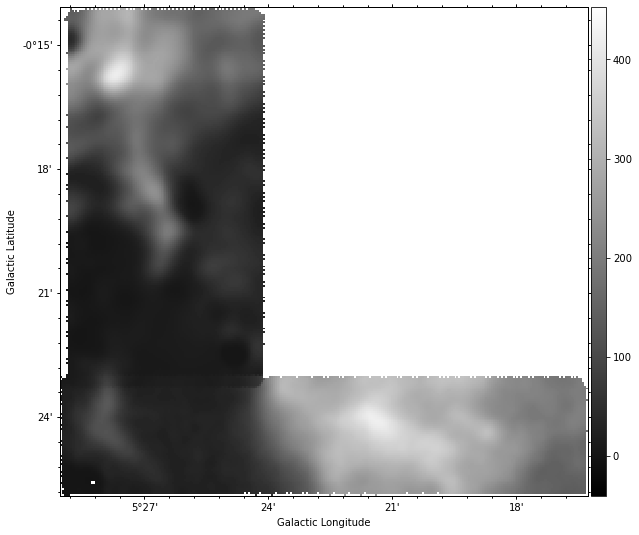

In [14]:
cube17b.moment0().quicklook()

In [15]:
mask17b = cube17b > 0.1 * u.K
mask17b

INFO: Auto-setting vmin to -4.048e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.573e+02 [aplpy.core]


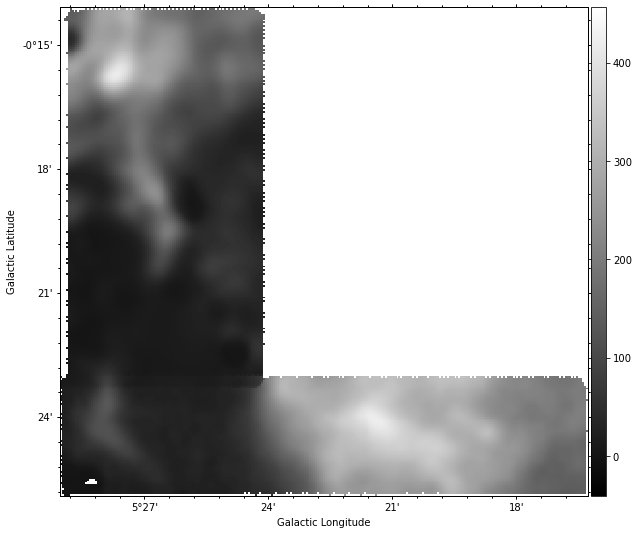

In [16]:
mom0_17b = cube17b.with_mask(mask17b).moment0()
(cube17b.with_mask(mask17b)).moment0().quicklook()

## 13CO

In [17]:
cube29a = cube_29.spectral_slab(75*u.km/u.s, 200*u.km/u.s)
cube29b = cube_29.spectral_slab(15*u.km/u.s, 75*u.km/u.s)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


INFO: Auto-setting vmin to -1.622e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.030e-01 [aplpy.core]


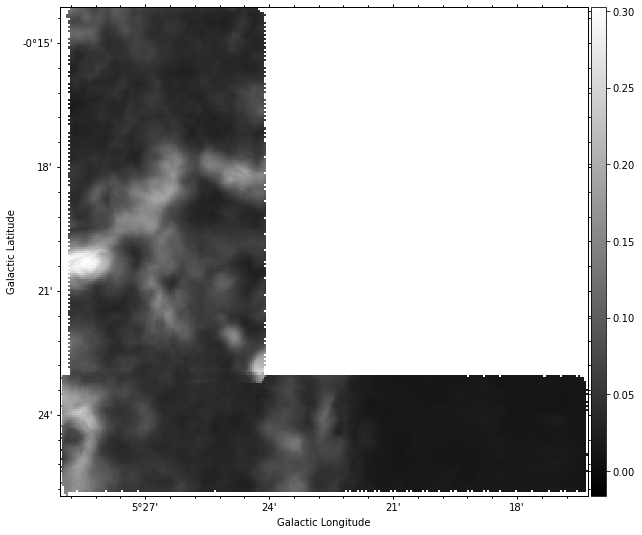

In [18]:
noise = cube29a.mad_std(axis=0)
noise.quicklook()

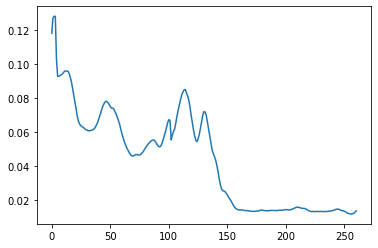

In [19]:
plt.plot(np.nanmean(noise,axis=0))
#plt.ylim(0, 1)

INFO: Auto-setting vmin to -7.777e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.646e+01 [aplpy.core]


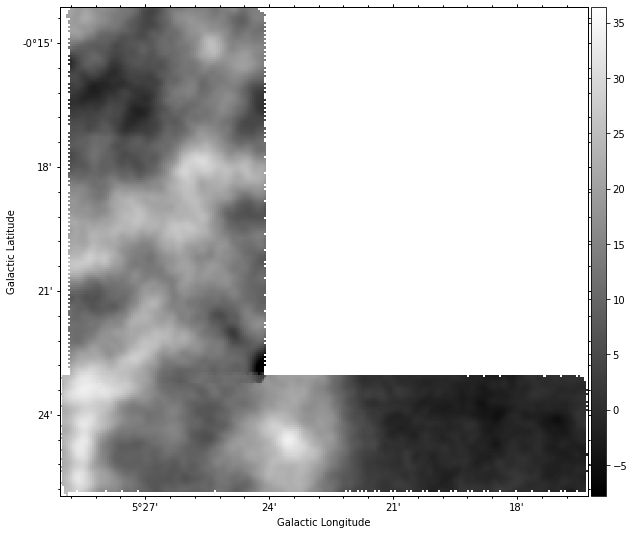

In [20]:
cube29a.moment0().quicklook()

In [21]:
mask29a = cube29a > 0.15 * u.K
mask29a

INFO: Auto-setting vmin to -2.956e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.374e+01 [aplpy.core]


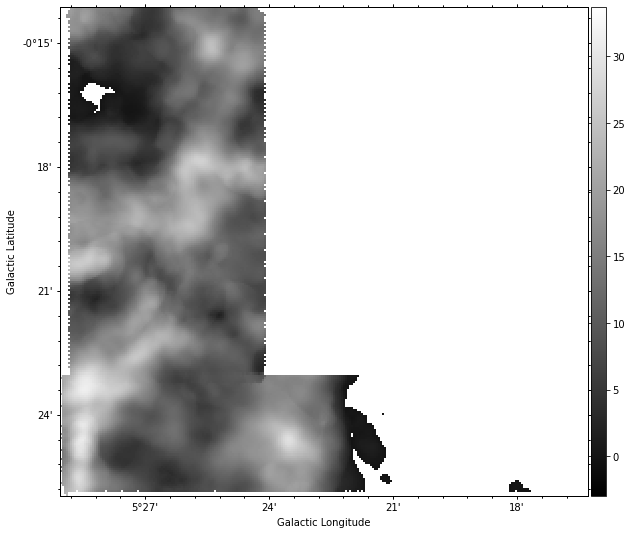

In [22]:
mom0_29a = (cube29a.with_mask(mask29a)).moment0()
(cube29a.with_mask(mask29a)).moment0().quicklook()

INFO: Auto-setting vmin to -1.007e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.478e+01 [aplpy.core]


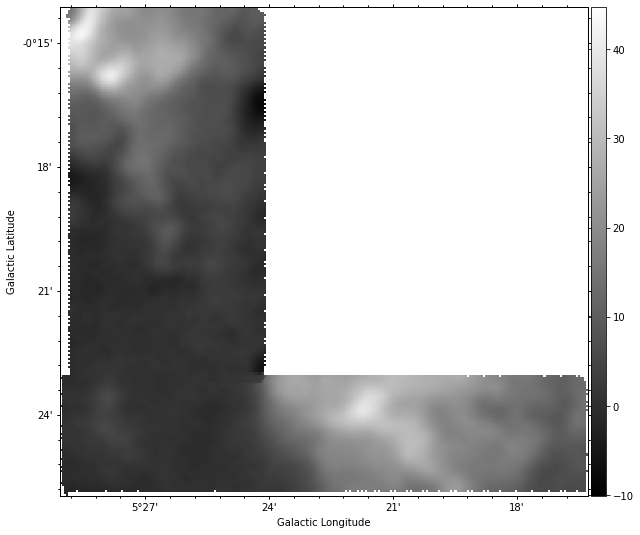

In [23]:
cube29b.moment0().quicklook()

In [24]:
mask29b = cube29b > 0.15 * u.K
mask29b

INFO: Auto-setting vmin to -3.786e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.264e+01 [aplpy.core]


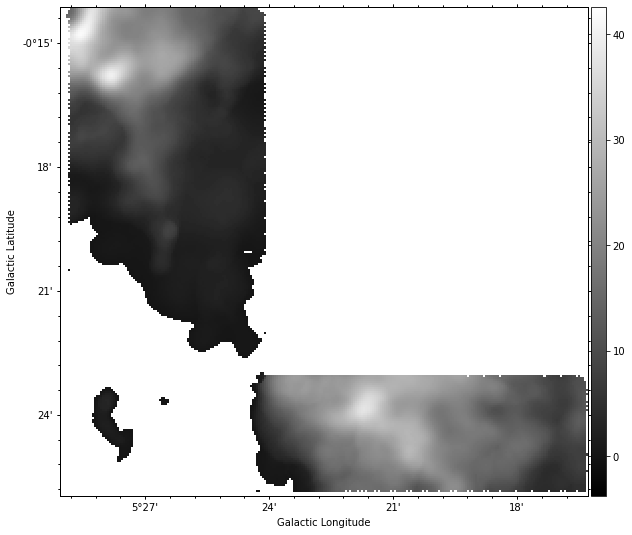

In [25]:
mom0_29b = (cube29b.with_mask(mask29b)).moment0()
(cube29b.with_mask(mask29b)).moment0().quicklook()

## C18O

In [26]:
cube31a = cube_31.spectral_slab(75*u.km/u.s, 200*u.km/u.s)
cube31b = cube_31.spectral_slab(15*u.km/u.s, 75*u.km/u.s)

INFO: Auto-setting vmin to -1.775e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.375e+00 [aplpy.core]


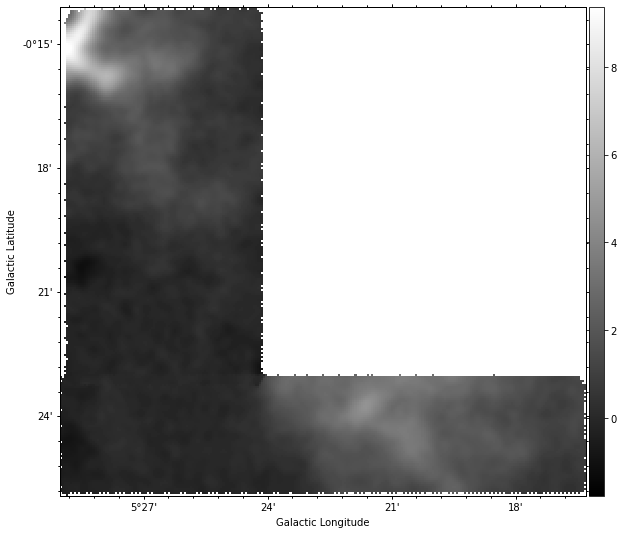

In [27]:
cube31b.moment0().quicklook()

In [28]:
mask31a = cube31a > 0.05 * u.K
mask31a

INFO: Auto-setting vmin to -2.872e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.391e+00 [aplpy.core]


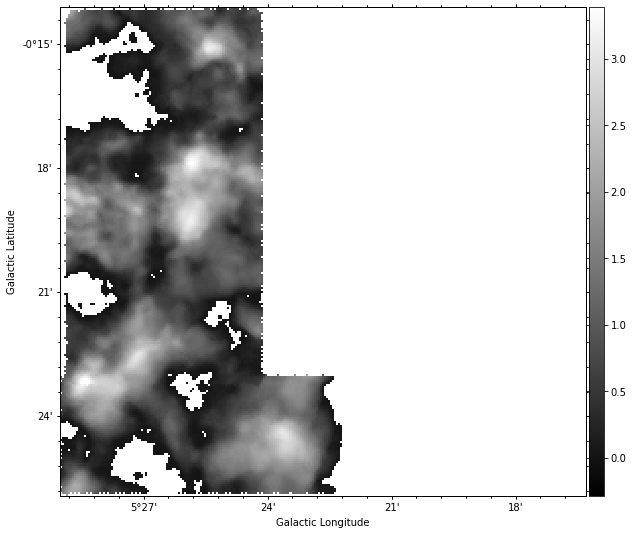

In [29]:
mom0_31a = (cube31a.with_mask(mask31a)).moment0()
(cube31a.with_mask(mask31a)).moment0().quicklook()

In [30]:
mask31b = cube31b > 0.05 * u.K
mask31b

INFO: Auto-setting vmin to -7.975e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.055e+00 [aplpy.core]


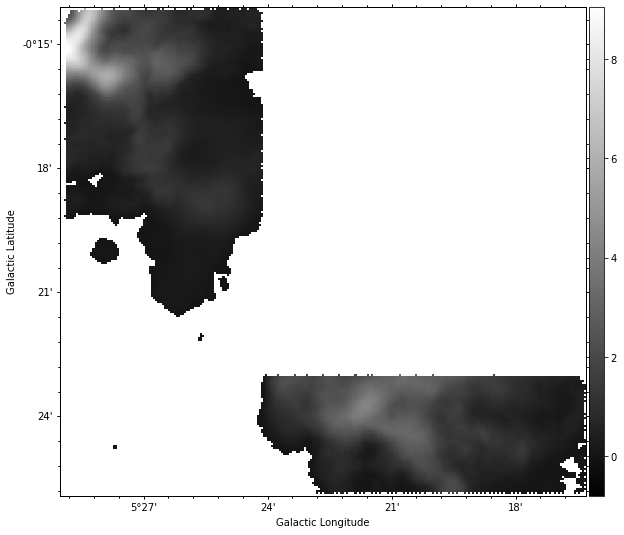

In [31]:
mom0_31b = (cube31b.with_mask(mask31b)).moment0()
(cube31b.with_mask(mask31b)).moment0().quicklook()

## Ratios

In [32]:
def ratio_formal(mom0_numer, mom0_denom, mask_numer):
    ratio = mom0_numer / (mom0_denom).reproject(header=mom0_numer.header)
    ratio = ratio*mask_numer
    # Ratio must be reasonable
    #try: 
    #    ratio[ratio > 5] = np.nan
    #except: 
    #    ratio[ratio > 5*u.K] = np.nan
    ratio.quicklook(use_aplpy=False)
    return ratio

### $^{13}$CO / $^{12}$CO

INFO: Auto-setting vmin to  1.020e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.914e-01 [aplpy.core]


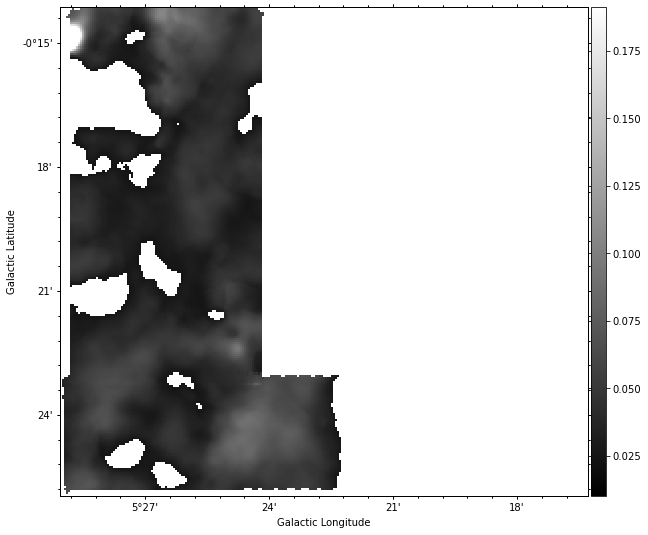

In [33]:
# 13CO / 12CO A
ratio_29_17_A = mom0_29a / mom0_17a.reproject(mom0_29a.header)
ratio_29_17_A[ratio_29_17_A < 0.025] = np.nan
ratio_29_17_A.quicklook(use_aplpy=True)

INFO: Auto-setting vmin to  3.402e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.322e+01 [aplpy.core]


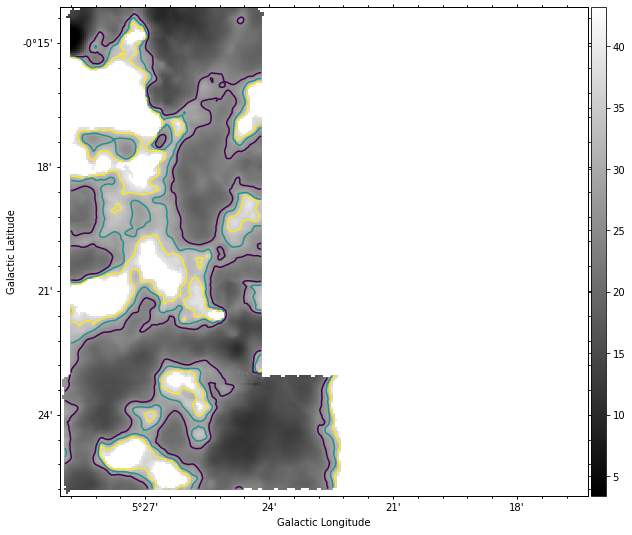

In [34]:
rat1729A = (ratio_29_17_A**(-1))
rat1729A.quicklook(use_aplpy=True)
rat1729A.FITSFigure.show_contour(rat1729A.hdu, levels=[25,30,35])

INFO: Auto-setting vmin to -2.436e-02 [aplpy.core]
INFO: Auto-setting vmax to  5.794e-01 [aplpy.core]


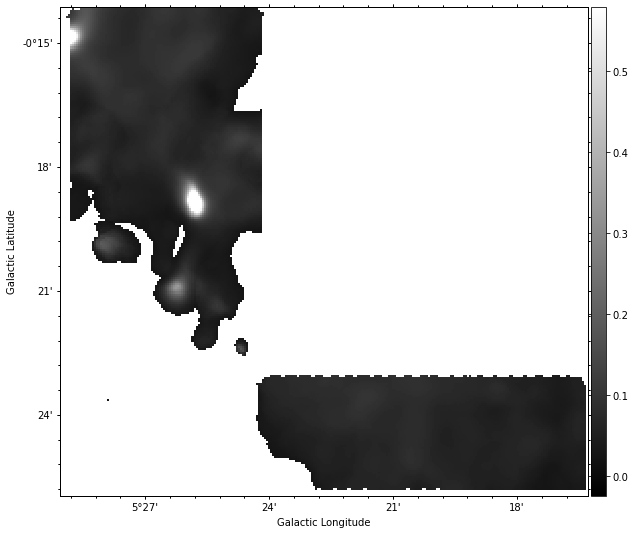

In [35]:
# 13CO / 12CO B
ratio_29_17_B = mom0_29b / mom0_17b.reproject(mom0_29b.header)
ratio_29_17_B[ratio_29_17_B < 0.025] = np.nan
ratio_29_17_B.quicklook()

INFO: Auto-setting vmin to -2.175e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.346e+01 [aplpy.core]


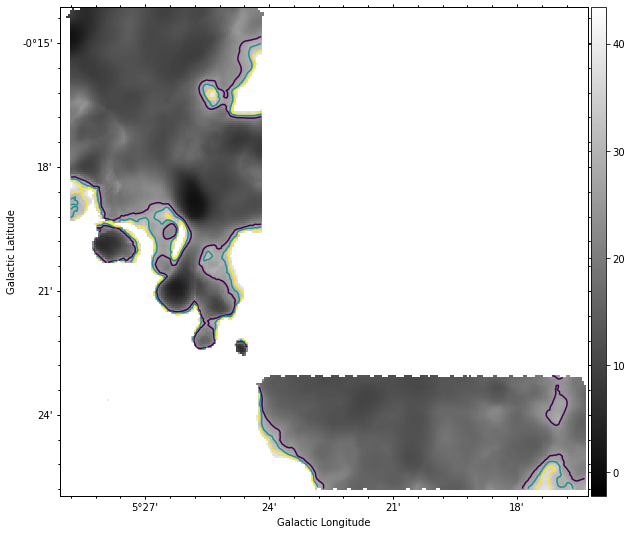

In [36]:
rat1729B = (ratio_29_17_B**(-1))
rat1729B.quicklook()
rat1729B.FITSFigure.show_contour(rat1729B.hdu, levels=[25,30,35])

INFO: Auto-setting vmin to  1.354e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.167e-01 [aplpy.core]


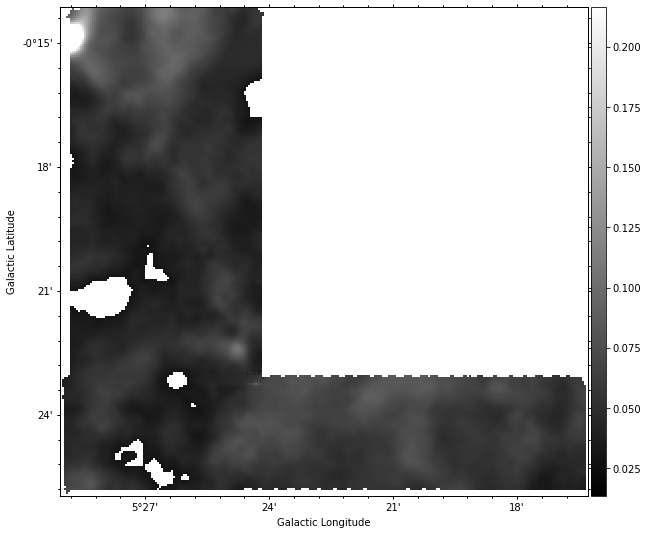

In [37]:
# 13CO / 12CO 
ratio_29_17 = mom0_29 / mom0_17.reproject(mom0_29.header)
ratio_29_17[ratio_29_17 < 0.03] = np.nan
ratio_29_17.quicklook()

INFO: Auto-setting vmin to  2.426e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.620e+01 [aplpy.core]


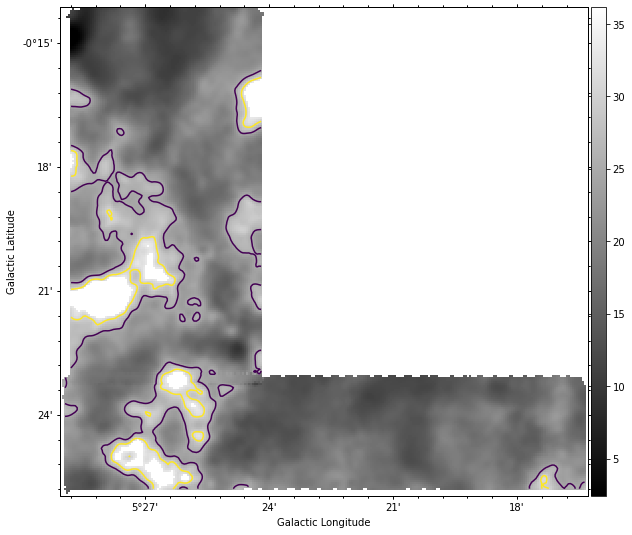

In [38]:
inv = (ratio_29_17**(-1))
inv.quicklook()
inv.FITSFigure.show_contour(inv.hdu, levels=[25,30])

### C$^{18}$O / $^{13}$CO

INFO: Auto-setting vmin to  7.928e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.604e-01 [aplpy.core]


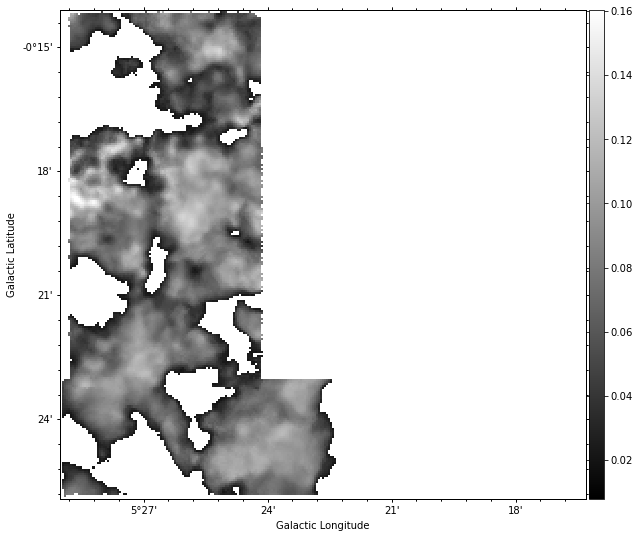

In [39]:
# C18O / 13CO A
ratio_31_29_A = mom0_31a / mom0_29a.reproject(mom0_31a.header)
ratio_31_29_A[ratio_31_29_A<0.02] = np.nan
ratio_31_29_A.quicklook()

INFO: Auto-setting vmin to  2.910e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.385e+01 [aplpy.core]


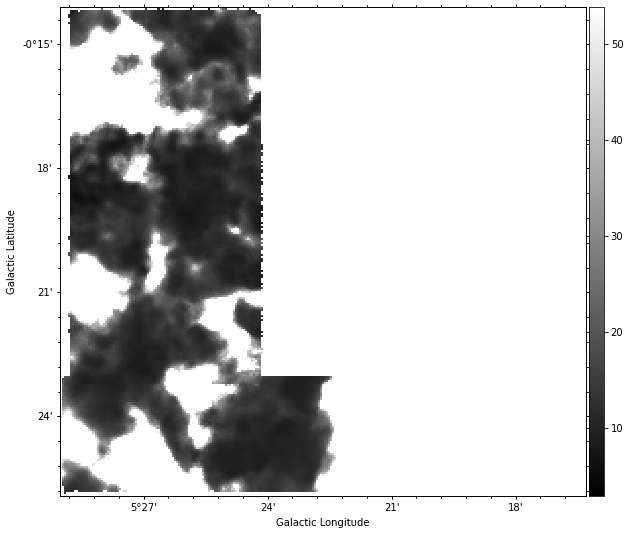

In [40]:
ratio_29_31_A = ratio_31_29_A**(-1)
ratio_29_31_A.quicklook()

INFO: Auto-setting vmin to -8.783e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.444e-01 [aplpy.core]


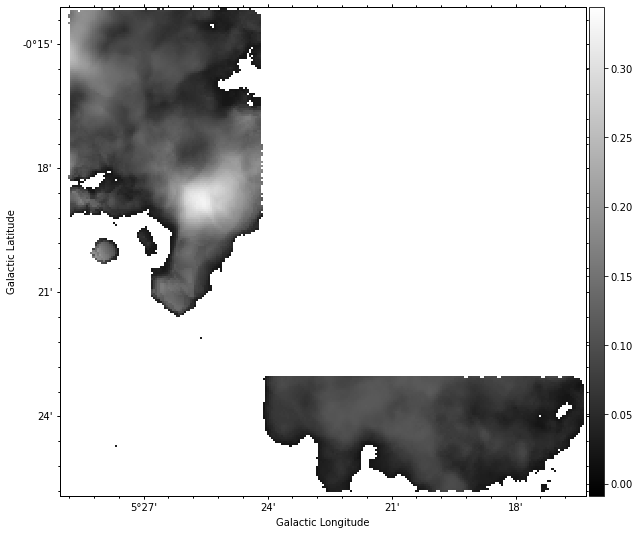

In [41]:
# C18O / 13CO B
ratio_31_29_B = mom0_31b / mom0_29b.reproject(mom0_31b.header)
ratio_31_29_B[ratio_31_29_B<0.02] = np.nan
ratio_31_29_B.quicklook()

INFO: Auto-setting vmin to -1.200e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.326e+01 [aplpy.core]


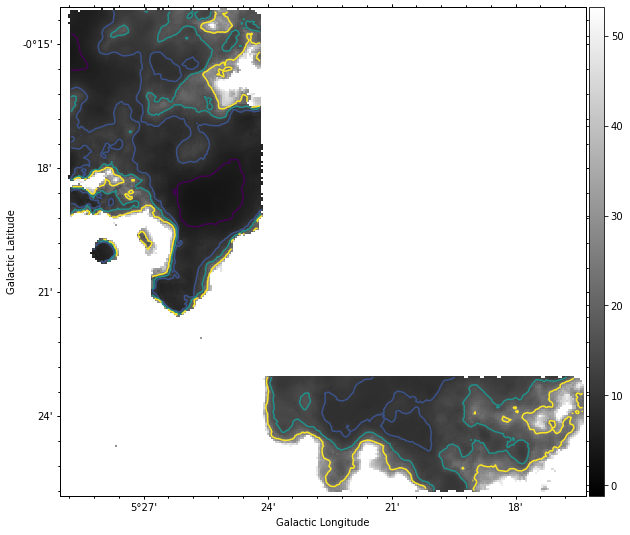

In [42]:
ratio_29_31_B = ratio_31_29_B**(-1)
ratio_29_31_B.quicklook()
ratio_29_31_B.FITSFigure.show_contour(ratio_29_31_B.hdu, levels=[5,10,15,25])

INFO: Auto-setting vmin to -7.675e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.847e-01 [aplpy.core]


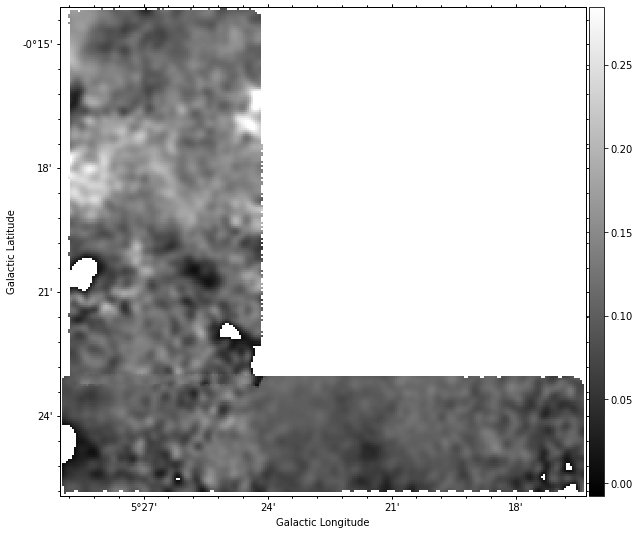

In [43]:
# C18O / 13CO 
ratio_31_29 = mom0_31 / mom0_29.reproject(mom0_31.header)
ratio_31_29[ratio_31_29<0.01] = np.nan
(ratio_31_29).quicklook()

INFO: Auto-setting vmin to -1.631e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.452e+01 [aplpy.core]


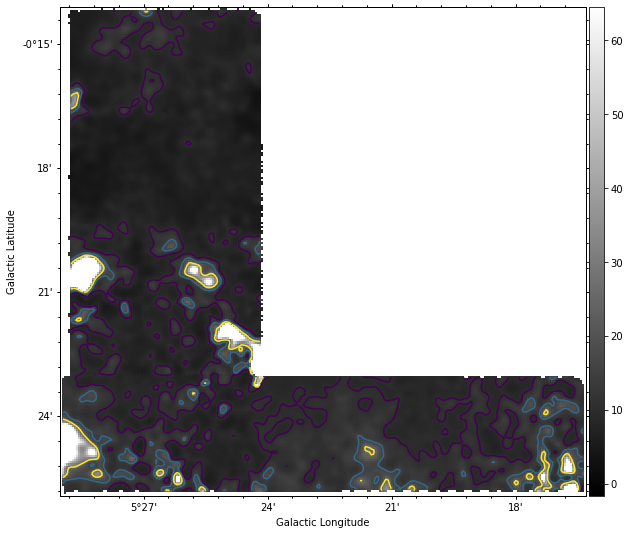

In [44]:
ratio_29_31 = ratio_31_29**(-1)
ratio_29_31.quicklook()
ratio_29_31.FITSFigure.show_contour(ratio_29_31.hdu, levels=[10,15,25])

### C$^{18}$O / $^{12}$CO

INFO: Auto-setting vmin to  1.070e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.243e-02 [aplpy.core]


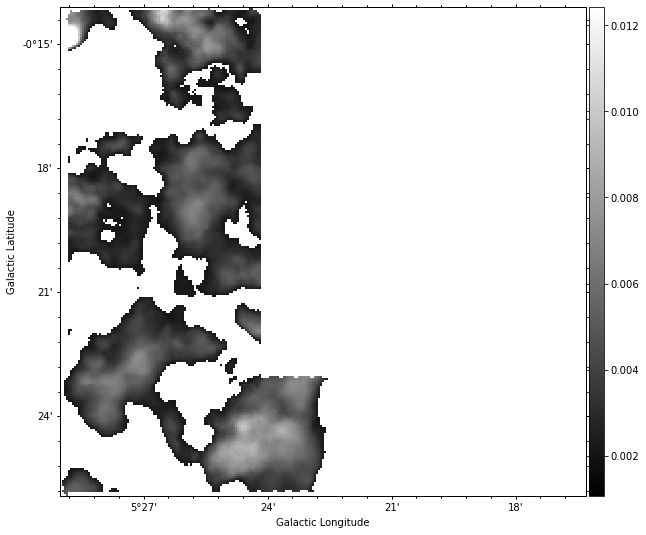

In [45]:
# C18O / 12CO A
ratio_31_17_A = mom0_31a / mom0_17a.reproject(mom0_31a.header)
ratio_31_17_A[ratio_31_17_A<0.002] = np.nan
ratio_31_17_A.quicklook()

INFO: Auto-setting vmin to  4.026e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.435e+02 [aplpy.core]


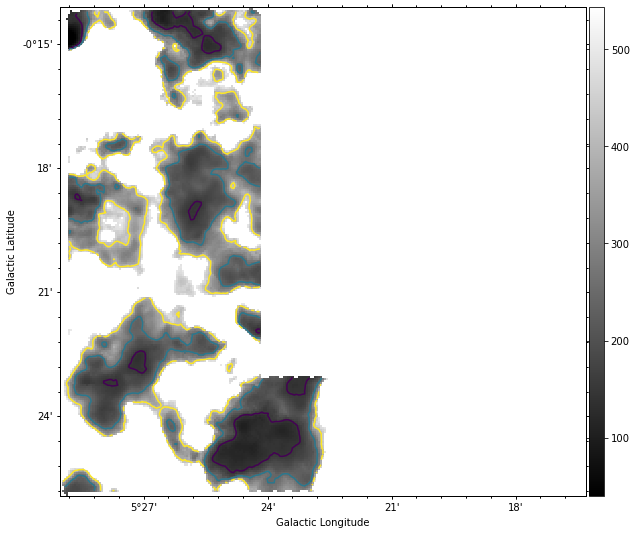

In [46]:
rat1731A = ratio_31_17_A**(-1)
rat1731A.quicklook()
rat1731A.FITSFigure.show_contour(rat1731A.hdu, levels=[150, 250, 400])

INFO: Auto-setting vmin to -1.492e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.900e-01 [aplpy.core]


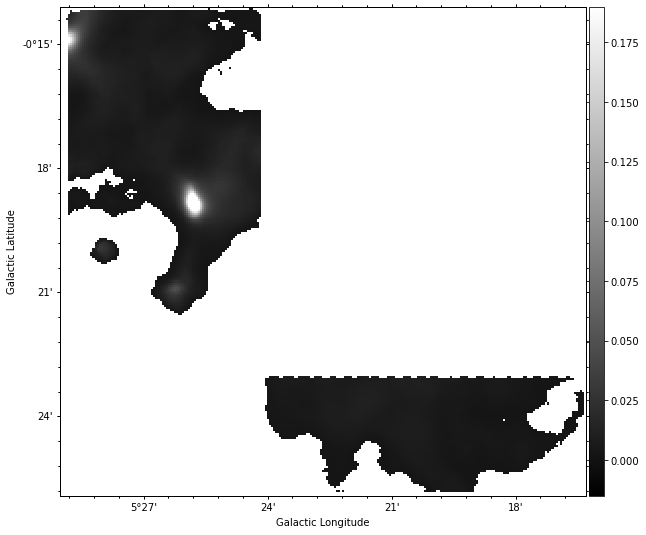

In [47]:
# C18O / 12CO B
ratio_31_17_B = mom0_31b / mom0_17b.reproject(mom0_31b.header)
ratio_31_17_B[ratio_31_17_B<0.002] = np.nan
(ratio_31_17_B).quicklook()

INFO: Auto-setting vmin to -4.341e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.492e+02 [aplpy.core]


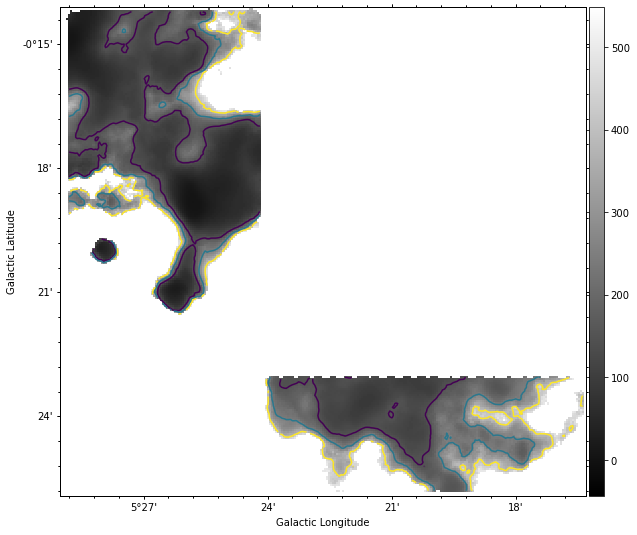

In [48]:
rat3117B = ratio_31_17_B**(-1)
rat3117B.quicklook()
rat3117B.FITSFigure.show_contour(rat3117B.hdu, levels=[150, 250, 400])

INFO: Auto-setting vmin to  6.863e-04 [aplpy.core]
INFO: Auto-setting vmax to  4.093e-02 [aplpy.core]


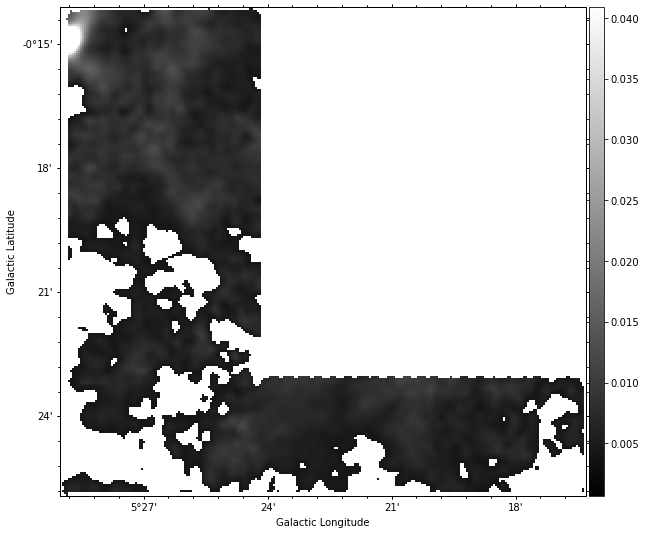

In [49]:
# C18O / 12CO 
ratio_31_17 = mom0_31 / mom0_17.reproject(mom0_31.header)
ratio_31_17[ratio_31_17<0.004] = np.nan
ratio_31_17.quicklook()

INFO: Auto-setting vmin to -2.866e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.746e+02 [aplpy.core]


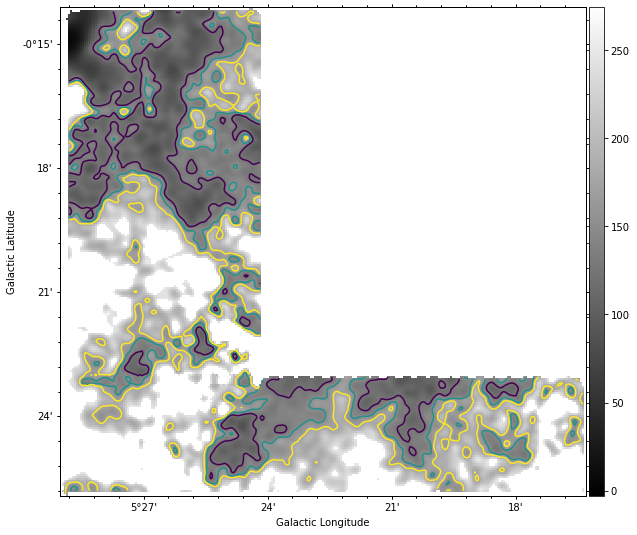

In [50]:
rat18 = (ratio_31_17**(-1))
rat18.quicklook()
rat18.FITSFigure.show_contour(rat18.hdu, levels=[125,150,175])

Comparing

INFO: Auto-setting vmin to  7.649e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.604e-01 [aplpy.core]


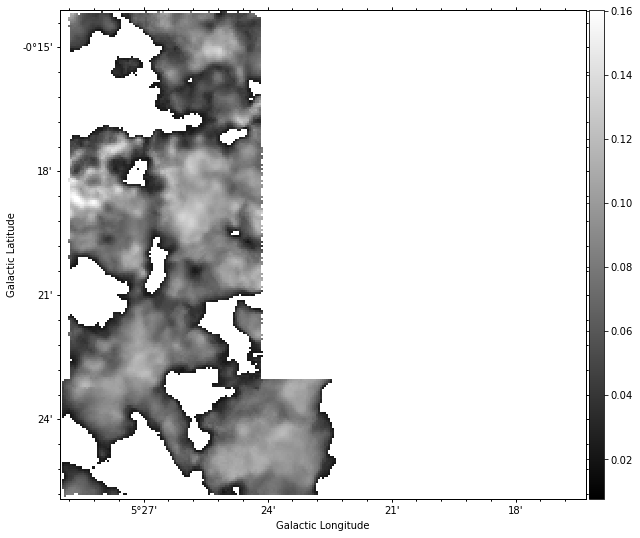

In [51]:
# C18O / 13CO A
ratio_31_29_A = mom0_31a / mom0_29a.reproject(mom0_31a.header)
ratio_31_29_A[ratio_31_29_A<0.02] = np.nan
ratio_31_29_A.quicklook()

INFO: Auto-setting vmin to  2.636e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.576e-01 [aplpy.core]


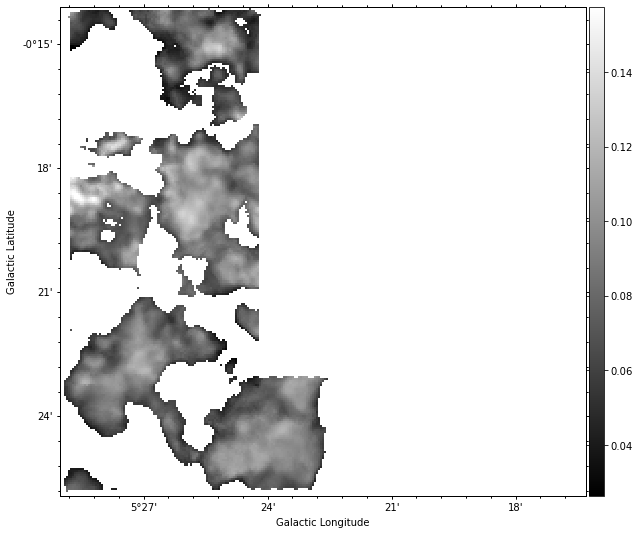

In [52]:
ratio_31_29_A12 = ratio_31_17_A / ratio_29_17_A.reproject(ratio_31_17_A.header)
ratio_31_29_A12.quicklook()

INFO: Auto-setting vmin to -3.279e-04 [aplpy.core]
INFO: Auto-setting vmax to  8.678e-04 [aplpy.core]


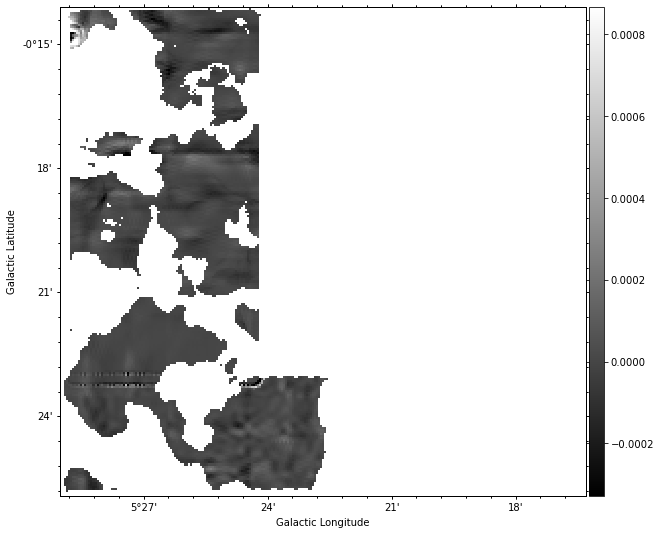

In [53]:
comp_a = ratio_31_29_A - ratio_31_29_A12
comp_a.quicklook()

INFO: Auto-setting vmin to -8.095e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.373e-01 [aplpy.core]


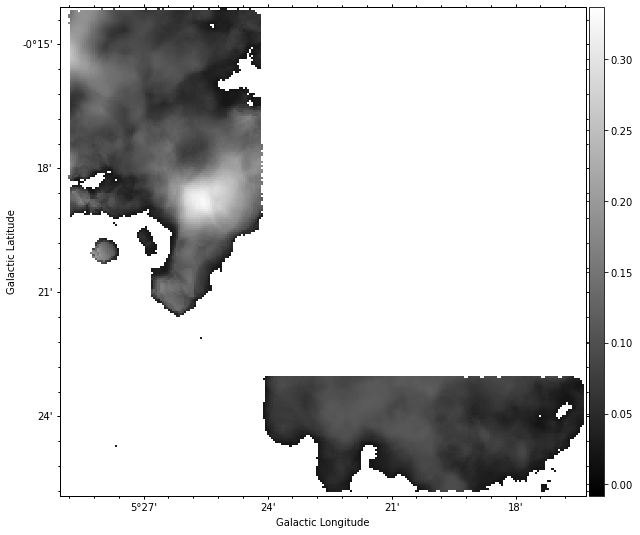

In [54]:
# C18O / 13CO B
ratio_31_29_B = mom0_31b / mom0_29b.reproject(mom0_31b.header)
ratio_31_29_B[ratio_31_29_B<0.02] = np.nan
ratio_31_29_B.quicklook()

INFO: Auto-setting vmin to  5.637e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.454e-01 [aplpy.core]


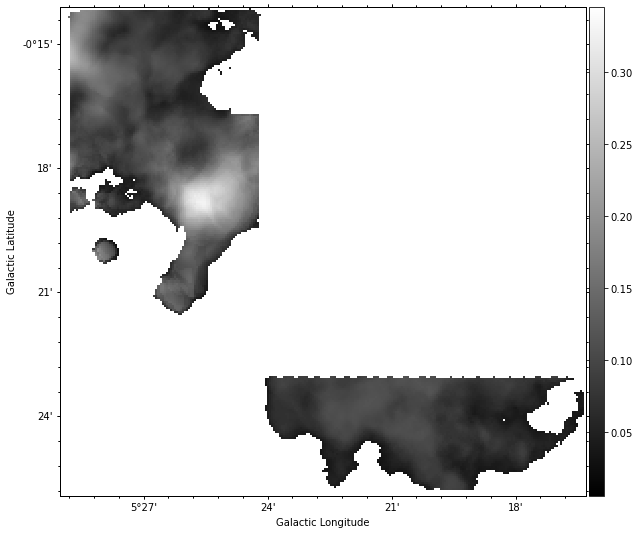

In [55]:
ratio_31_29_B12 = ratio_31_17_B / ratio_29_17_B.reproject(ratio_31_17_B.header)
ratio_31_29_B12.quicklook()

INFO: Auto-setting vmin to -2.347e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.697e-03 [aplpy.core]


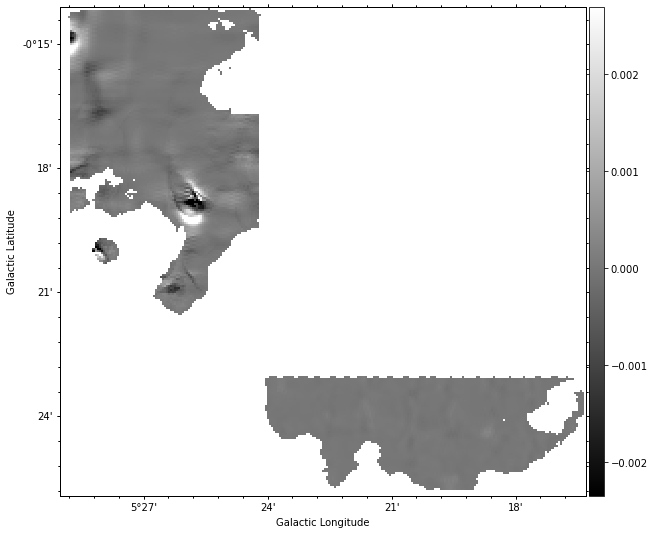

In [56]:
comp_b = ratio_31_29_B - ratio_31_29_B12
comp_b.quicklook()

INFO: Auto-setting vmin to -7.957e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.813e-01 [aplpy.core]


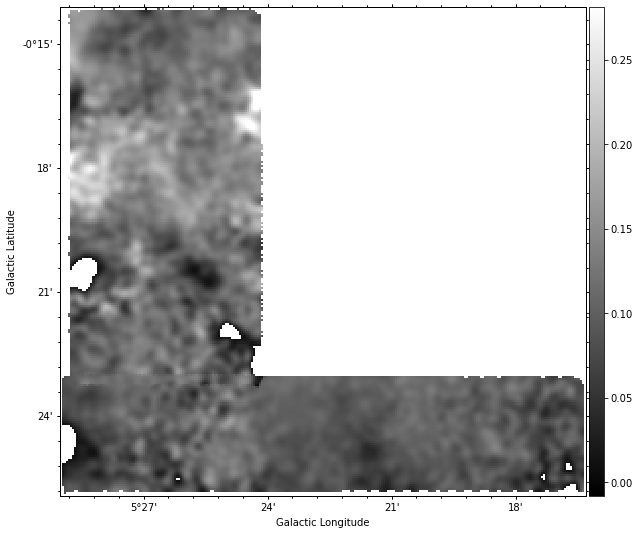

In [57]:
# C18O / 13CO 
ratio_31_29 = mom0_31 / mom0_29.reproject(mom0_31.header)
ratio_31_29[ratio_31_29<0.01] = np.nan
(ratio_31_29).quicklook()

INFO: Auto-setting vmin to  4.456e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.763e-01 [aplpy.core]


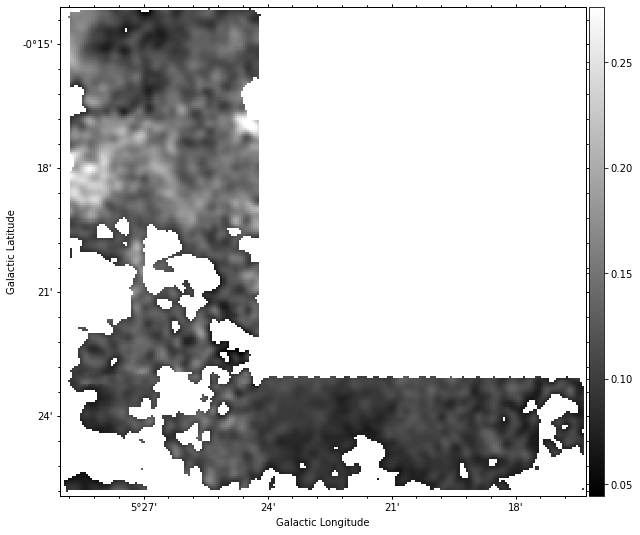

In [58]:
ratio_31_29_12 = ratio_31_17 / ratio_29_17.reproject(ratio_31_17.header)
ratio_31_29_12.quicklook()

INFO: Auto-setting vmin to -6.852e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.187e-03 [aplpy.core]


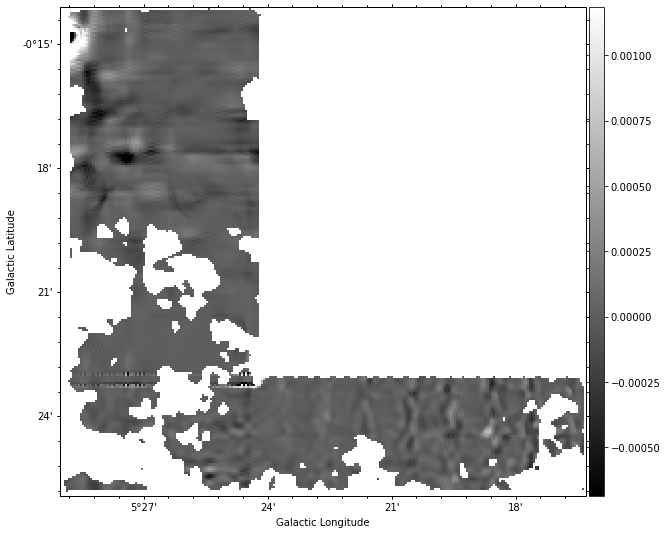

In [59]:
comp = ratio_31_29 - ratio_31_29_12
comp.quicklook()

## Plotting

In [60]:
def mean_ratio(ratio):
    return np.nanmean(ratio, axis=0)
def std_ratio(ratio):
    return np.nanstd(ratio, axis=0)

In [61]:
ratio_29_17_A_mean = mean_ratio(ratio_29_17_A)
ratio_29_17_B_mean = mean_ratio(ratio_29_17_B)
ratio_31_29_A_mean = mean_ratio(ratio_31_29_A)
ratio_31_29_B_mean = mean_ratio(ratio_31_29_B)
ratio_31_17_A_mean = mean_ratio(ratio_31_17_A)
ratio_31_17_B_mean = mean_ratio(ratio_31_17_B)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice


In [62]:
#plt.errorbar(x=x,y=mean_tempb_h2co_masked,yerr=std_tempb_h2co, alpha=0.2, color='tab:orange')
ratio_29_17_A_std = std_ratio(ratio_29_17_A)
ratio_29_17_B_std = std_ratio(ratio_29_17_B)
ratio_31_29_A_std = std_ratio(ratio_31_29_A)
ratio_31_29_B_std = std_ratio(ratio_31_29_B)
ratio_31_17_A_std = std_ratio(ratio_31_17_A)
ratio_31_17_B_std = std_ratio(ratio_31_17_B)

<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


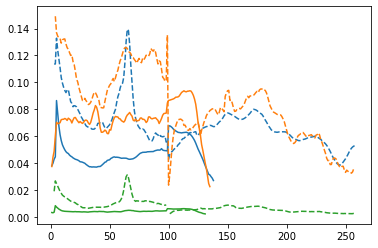

In [63]:
plt.plot(ratio_29_17_A_mean, color = 'tab:blue')
plt.plot(ratio_29_17_B_mean, color = 'tab:blue', linestyle='dashed')
plt.plot(ratio_31_29_A_mean, color = 'tab:orange')
plt.plot(ratio_31_29_B_mean, color = 'tab:orange', linestyle='dashed')
plt.plot(ratio_31_17_A_mean, color = 'tab:green')
plt.plot(ratio_31_17_B_mean, color = 'tab:green', linestyle='dashed')

In [64]:
ww = wcs.WCS(mom0_31a.header)
pixelarea = ww.proj_plane_pixel_area()
x = np.arange(len(ratio_31_29_A_mean)) * np.sqrt(pixelarea.to(u.rad**2)).to(u.arcmin)

ww2 = wcs.WCS(mom0_29a.header)
pixelarea2 = ww2.proj_plane_pixel_area()
x2 = np.arange(len(ratio_29_17_A_mean)) * np.sqrt(pixelarea2.to(u.rad**2)).to(u.arcmin)
#plt.plot(x, mean_ratioo)

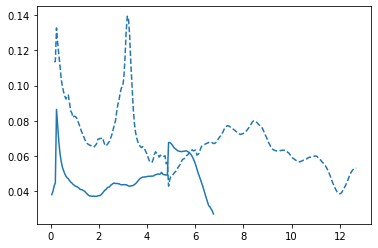

In [65]:
ratio_29_17_A_mean[ratio_29_17_A_mean<0.02] = np.nan
ratio_29_17_B_mean[ratio_29_17_B_mean<0.02] = np.nan

plt.plot(x2, ratio_29_17_A_mean, color = 'tab:blue')
plt.plot(x2, ratio_29_17_B_mean, color = 'tab:blue', linestyle='dashed')

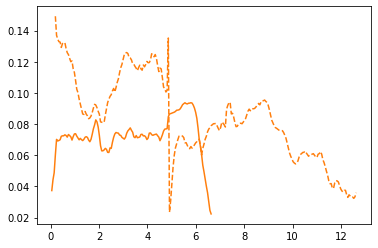

In [66]:
ratio_31_29_A_mean[ratio_31_29_A_mean<0.02] = np.nan
ratio_31_29_B_mean[ratio_31_29_B_mean<0.02] = np.nan

plt.plot(x,  ratio_31_29_A_mean, color = 'tab:orange')
plt.plot(x,  ratio_31_29_B_mean, color = 'tab:orange', linestyle='dashed')

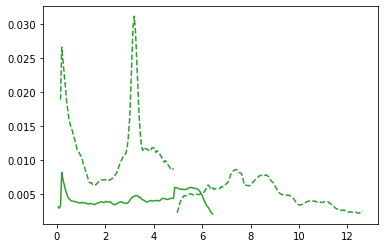

In [67]:
ratio_31_17_A_mean[ratio_31_17_A_mean<0.001] = np.nan
ratio_31_17_B_mean[ratio_31_17_B_mean<0.001] = np.nan

plt.plot(x,  ratio_31_17_A_mean, color = 'tab:green')
plt.plot(x,  ratio_31_17_B_mean, color = 'tab:green', linestyle='dashed')

Text(0, 0.5, 'Ratio [Brighter/Dimmer]')

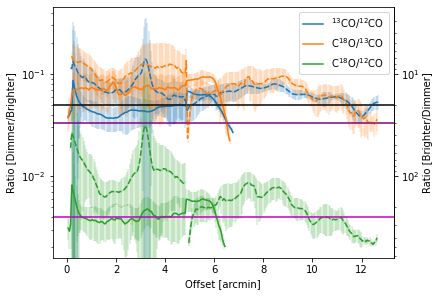

In [68]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(6,4))

ax.errorbar(x2, ratio_29_17_A_mean, ratio_29_17_A_std, alpha = 0.2, color = 'tab:blue')
ax.errorbar(x2, ratio_29_17_B_mean, ratio_29_17_B_std, alpha = 0.2, color = 'tab:blue')
ax.errorbar(x,  ratio_31_29_A_mean, ratio_31_29_A_std, alpha = 0.2, color = 'tab:orange')
ax.errorbar(x,  ratio_31_29_B_mean, ratio_31_29_B_std, alpha = 0.2, color = 'tab:orange')
ax.errorbar(x,  ratio_31_17_A_mean, ratio_31_17_A_std, alpha = 0.2, color = 'tab:green')
ax.errorbar(x,  ratio_31_17_B_mean, ratio_31_17_B_std, alpha = 0.2, color = 'tab:green')

ax.semilogy(x2, ratio_29_17_A_mean, color = 'tab:blue', label='$^{13}$CO/$^{12}$CO')
ax.plot(x2, ratio_29_17_B_mean, color = 'tab:blue', linestyle='dashed')
ax.plot(x,  ratio_31_29_A_mean, color = 'tab:orange', label='C$^{18}$O/$^{13}$CO')
ax.plot(x,  ratio_31_29_B_mean, color = 'tab:orange', linestyle='dashed')
ax.plot(x,  ratio_31_17_A_mean, color = 'tab:green', label='C$^{18}$O/$^{12}$CO')
ax.plot(x,  ratio_31_17_B_mean, color = 'tab:green', linestyle='dashed')
ax.set_xlabel('Offset [arcmin]')
ax.set_ylabel('Ratio [Dimmer/Brighter]')
ax.legend()

ax.axhline(1/20, color='black')
ax.axhline(1/30, color='purple')
ax.axhline(1/250, color='m')
#plt.ylim(0.002,0.12)
def inverse(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x
secax = ax.secondary_yaxis('right',functions=(inverse, inverse))
secax.set_ylabel('Ratio [Brighter/Dimmer]')
#plt.savefig('plots/isoratios.pdf')

In [69]:
425/30

14.166666666666666

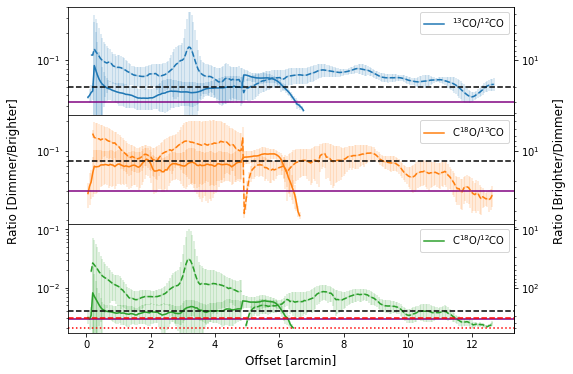

In [70]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})#, constrained_layout=True)

axs[0].errorbar(x2, ratio_29_17_A_mean, ratio_29_17_A_std, alpha = 0.2, color = 'tab:blue')
axs[0].errorbar(x2, ratio_29_17_B_mean, ratio_29_17_B_std, alpha = 0.2, color = 'tab:blue')
axs[1].errorbar(x,  ratio_31_29_A_mean, ratio_31_29_A_std, alpha = 0.2, color = 'tab:orange')
axs[1].errorbar(x,  ratio_31_29_B_mean, ratio_31_29_B_std, alpha = 0.2, color = 'tab:orange')
axs[2].errorbar(x,  ratio_31_17_A_mean, ratio_31_17_A_std, alpha = 0.2, color = 'tab:green')
axs[2].errorbar(x,  ratio_31_17_B_mean, ratio_31_17_B_std, alpha = 0.2, color = 'tab:green')

axs[0].semilogy(x2, ratio_29_17_A_mean, color = 'tab:blue', label='$^{13}$CO/$^{12}$CO')
axs[0].plot(x2, ratio_29_17_B_mean, color = 'tab:blue', linestyle='dashed')
axs[1].semilogy(x,  ratio_31_29_A_mean, color = 'tab:orange', label='C$^{18}$O/$^{13}$CO')
axs[1].plot(x,  ratio_31_29_B_mean, color = 'tab:orange', linestyle='dashed')
axs[2].semilogy(x,  ratio_31_17_A_mean, color = 'tab:green', label='C$^{18}$O/$^{12}$CO')
axs[2].plot(x,  ratio_31_17_B_mean, color = 'tab:green', linestyle='dashed')

for ax in axs.flat:
    ax.legend()
    ax.label_outer()  
    
def inverse(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

axs[0].axhline(1/20, color='black', linestyle='dashed') # 12/13
axs[0].axhline(1/30, color='purple')
#axs[0].axhline(1/90, color='red', linestyle='dotted') 

axs[1].axhline(20/250, color='black', linestyle='dashed') # 12/13
#axs[1].axhline(30/425, color='purple')
axs[1].axhline(1/25, color='purple')
#axs[1].axhline(500/90, color='red', linestyle='dotted') 

axs[2].axhline(1/250, color='black', linestyle='dashed') # 12/18
axs[2].axhline(1/350, color='purple')
axs[2].axhline(1/490, color='red', linestyle='dotted') 
axs[2].axhline(1/327, color='red', linestyle='dashed') 
#axs[2].axhline(1/(327+32), color='red', linestyle='dashed') 
#axs[2].axhline(1/(327-32), color='red', linestyle='dashed') 

secax0 = axs[0].secondary_yaxis('right',functions=(inverse, inverse))
secax1 = axs[1].secondary_yaxis('right',functions=(inverse, inverse))
secax2 = axs[2].secondary_yaxis('right',functions=(inverse, inverse))
    
plt.xlabel('Offset [arcmin]', fontsize=12)
fig.supylabel('Ratio [Dimmer/Brighter]', horizontalalignment='left')#, fontsize=16)
#plt.ylabel('Ratio [Brighter/Dimmer]')
plt.text(x=0.99, y=0.5, s='Ratio [Brighter/Dimmer]', rotation='vertical', transform=fig.transFigure, ha='right',va='center', fontsize=12)
#fig.supylabel('Ratio [Brighter/Dimmer]', x=1.01)#, horizontalalignment='center')

fig.set_figheight(6)
fig.set_figwidth(8)


#plt.savefig('plots/isotopologue.pdf', bbox_inches='tight')

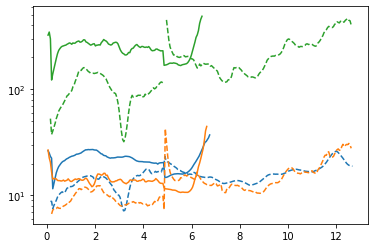

In [71]:
plt.plot(x2, np.power(ratio_29_17_A_mean, -1.), color = 'tab:blue')
plt.plot(x2, np.power(ratio_29_17_B_mean, -1.), color = 'tab:blue', linestyle='dashed')
plt.plot(x,  np.power(ratio_31_29_A_mean, -1.), color = 'tab:orange')
plt.plot(x,  np.power(ratio_31_29_B_mean, -1.), color = 'tab:orange', linestyle='dashed')
plt.plot(x,  np.power(ratio_31_17_A_mean, -1.), color = 'tab:green')
plt.plot(x,  np.power(ratio_31_17_B_mean, -1.), color = 'tab:green', linestyle='dashed')
plt.yscale('log')

### Opacity

In [72]:
def funct(tau, A): # = R
    #A = 30
    return (1-np.e**(-tau))/(1-np.e**(-tau/A))

def F(tau, R=20, A=30):
    return R - funct(tau, A)

def F_1218(tau, R=200, A=250):
    return R - funct(tau, A)

# fsolve(function, tau guesses, R) # Returns the R
#fsolve(F, np.linspace(0.1, 1.0, num=10), np.linspace(15, 25, num=10), )

In [73]:
taus = np.ones(np.nan_to_num(ratio_29_17_A**(-1)).shape)
rat = np.nan_to_num(ratio_29_17_A**(-1))

for t in range(len(taus)):
    taus[t] = (fsolve(F, taus[t], rat[t]))*(rat[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [74]:
#taus[taus>5] = 0
taus[taus<0] = 0



INFO: Auto-setting vmin to -2.790e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.097e+00 [aplpy.core]


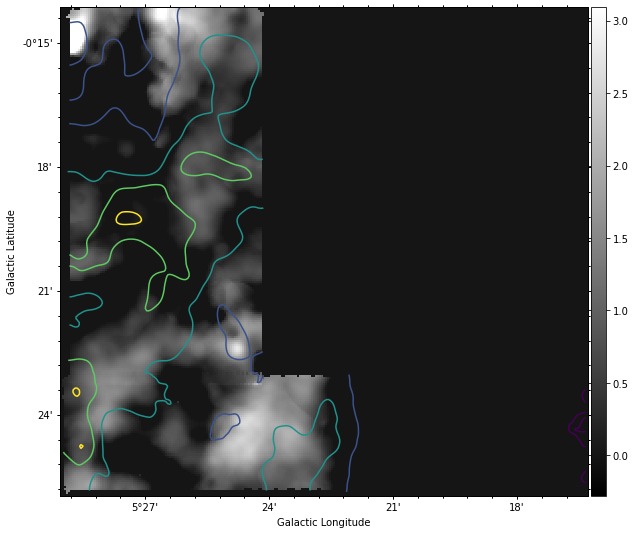

In [75]:
pro = Projection(value=taus, wcs=ratio_29_17_A.wcs)
pro.quicklook()
pro.FITSFigure.show_contour(data=mom0_17a.hdu)


In [76]:
taus_1218 = np.ones(np.nan_to_num(ratio_31_17**(-1)).shape)
rat_1218 = np.nan_to_num(ratio_31_17**(-1))

for t in range(len(taus_1218)):
    taus_1218[t] = (fsolve(F_1218, taus_1218[t], rat_1218[t]))*(rat_1218[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [77]:
taus_1218[taus_1218>5] = 0
taus_1218[taus_1218<0] = 0



INFO: Auto-setting vmin to -3.301e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.664e+00 [aplpy.core]


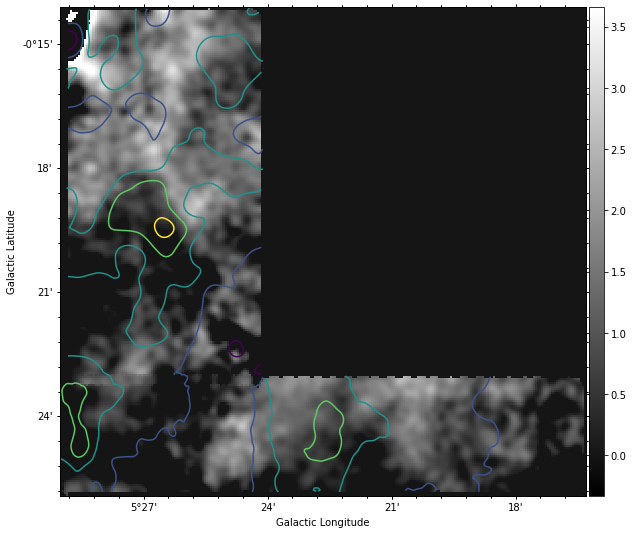

In [78]:
pro_1218 = Projection(value=taus_1218, wcs=ratio_31_17.wcs)
pro_1218.quicklook()
pro_1218.FITSFigure.show_contour(data=mom0_17.hdu)


In [79]:
taus_B = np.ones(np.nan_to_num(ratio_29_17_B**(-1)).shape)
rat_B = np.nan_to_num(ratio_29_17_B**(-1))

for t in range(len(taus_B)):
    taus_B[t] = (fsolve(F, taus_B[t], rat_B[t]))*(rat_B[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [80]:
taus_B[taus_B>5] = 0
taus_B[taus_B<0] = 0


INFO: Auto-setting vmin to -4.246e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.713e+00 [aplpy.core]


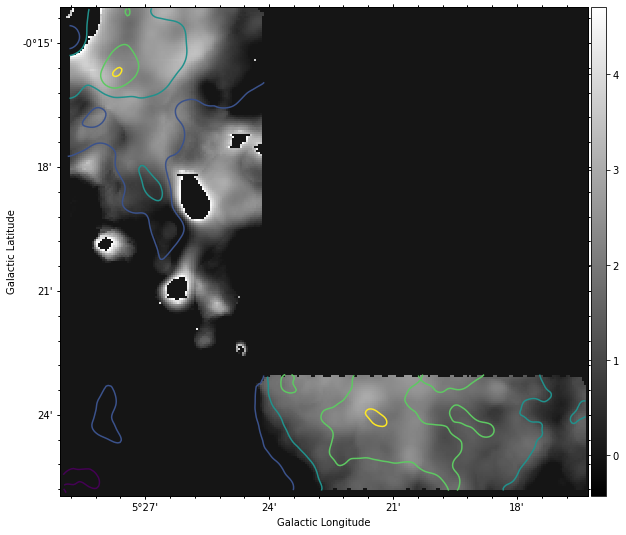

In [81]:
pro3 = Projection(value=taus_B, wcs=ratio_29_17_B.wcs)
pro3.quicklook()
pro3.FITSFigure.show_contour(data=mom0_17b.hdu)


In [181]:
taus_all = np.ones(np.nan_to_num(ratio_29_17**(-1)).shape)
rat_all = np.nan_to_num(ratio_29_17**(-1))

for t in range(len(taus_all)):
    taus_all[t] = (fsolve(F, taus_all[t], rat_all[t]))*(rat_all[t] != 0)
    

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [183]:
taus_all[taus_all>10] = np.nan
taus_all[taus_all<=0] = np.nan

In [171]:
coord = SkyCoord(5.4*u.deg, -22*u.arcmin, frame=Galactic)
coord.to_pixel(wcs=ratio_29_17.wcs)

(array(102.95607551), array(80.39721285))

INFO: Auto-setting vmin to -4.424e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.060e+00 [aplpy.core]


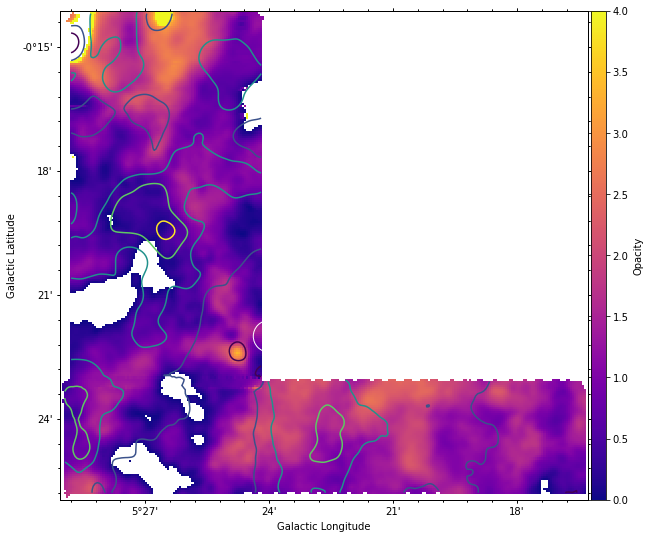

In [185]:
pro4 = Projection(value=taus_all, wcs=ratio_29_17.wcs)
pro4.quicklook()
#pro4.FITSFigure.show_contour(data=mom0_17.hdu)
pro4.FITSFigure.show_contour(data=mom0_17.reproject(mom0_29.header).hdu)
pro4.FITSFigure.show_colorscale(cmap='plasma', vmin=0, vmax=4)
pro4.FITSFigure.colorbar.set_axis_label_text('Opacity')
pro4.FITSFigure.show_markers(coord.to_pixel(wcs=ratio_29_17.wcs)[0], coord.to_pixel(wcs=ratio_29_17.wcs)[1], coords_frame='pixel', layer=True, c='none', edgecolor='white', s=1000)
pro4.FITSFigure.show_markers(coord.l, coord.b, marker='x', c='white')
#pro4.FITSFigure.savefig('/orange/adamginsburg/cmz/g5/code/plots/opacity_est.pdf')

In [165]:
coord = SkyCoord(5.4*u.deg, -0.30*u.deg, frame=Galactic)
coord.to_pixel(wcs=ratio_29_17.wcs)

(array(102.95615842), array(162.1443853))

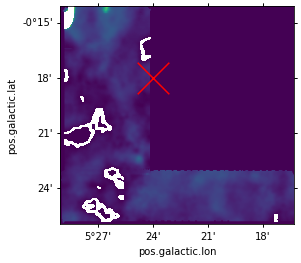

In [166]:
plt.subplot(111, projection=pro4.wcs.celestial)
pro4.quicklook(use_aplpy=False)
plt.scatter(coord.to_pixel(wcs=ratio_29_17.wcs)[0], coord.to_pixel(wcs=ratio_29_17.wcs)[1], marker='x', s=1000, color='red')

In [85]:
np.nanstd(pro4[5:,5:100])

<Projection 0.77297931>

In [86]:
ww = wcs.WCS(ratio_29_17.header)
pixelarea = ww.proj_plane_pixel_area()
x_tau = np.arange(len(np.nanmean(pro, axis=0))) * np.sqrt(pixelarea.to(u.rad**2)).to(u.arcmin)

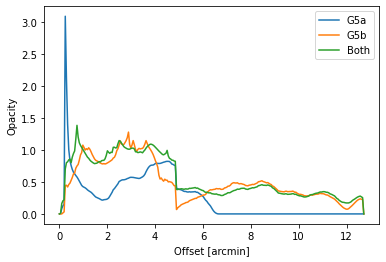

In [87]:
plt.plot(x_tau, np.nanmean(pro, axis=0), label='G5a')
plt.plot(x_tau, np.nanmean(pro3, axis=0), label='G5b')
plt.plot(x_tau, np.nanmean(pro4,axis=0), label='Both')
plt.ylabel('Opacity')
plt.xlabel('Offset [arcmin]')
plt.legend()

In [88]:
Tex = 60 * u.K
Tbg = 2.725 * u.K
mu = (1.1079*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
J = 2
S = J / (2*J+1)

In [89]:
def planck(T, nu):
    return (const.h*nu/const.k_B)/(np.exp(const.h*nu/(const.k_B*T))-1)

In [90]:
# 12CO
Eu_12 = 16.59608 * u.K
freq_12 = (230.5380000 * u.GHz).to(u.Hz)
B0 = 57635.968*u.MHz
Q_rot_12 = const.k_B * Tex / (const.h * B0) + 1./3.
one = (3 * const.h)/(8 * np.pi**3 * S * mu**2) 
two = Q_rot_12/(2*J+1)
three = np.exp(Eu_12/(Tex))/(np.exp(const.h * freq_12/(const.k_B * Tex))-1)
four = (planck(Tex, freq_12)-planck(Tbg, freq_12))**(-1)
I0 = 800 * u.K * (u.km / u.second)#.to(u.Hz, equivalencies=u.doppler_radio(freq_12))

N = one * two * three * four * I0

In [91]:
(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)).to(u.esu)

1.0

In [92]:
N.to(u.cm**(-2))
#.to(u.K * u.second**2 / (u.cm * u.g))


<Quantity 6.87957682e+17 1 / cm2>

INFO: Auto-setting vmin to  6.709e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.531e+02 [aplpy.core]


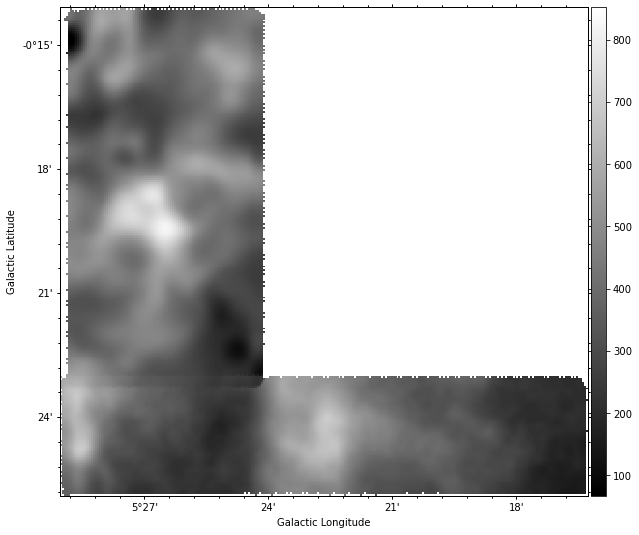

In [93]:
#plt.subplot(111, projection=mom0_17.wcs.celestial)
mom0_17=cube_17.with_mask(cube_17>0.05*u.K).spectral_slab(15*u.km/u.s, 200*u.km/u.s).moment0()
mom0_17.quicklook()
#cb = plt.colorbar()
#cb.set_label(mom0_17.unit)

In [94]:
mom0_17.unit

Unit("K km / s")

INFO: Auto-setting vmin to  5.334e+16 [aplpy.core]
INFO: Auto-setting vmax to  7.376e+17 [aplpy.core]


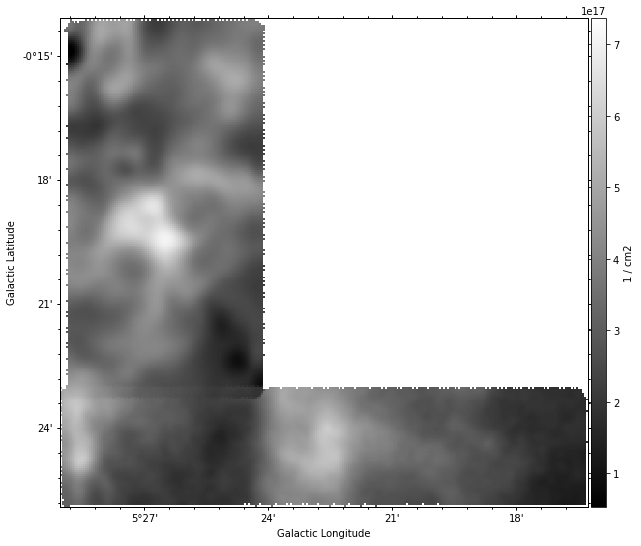

In [95]:
#save = (one * two * three * four * mom0_17).to(u.cm**(-2))
save = (one * two * three * four * mom0_17).to(u.cm**(-2))
save.quicklook()
save.FITSFigure.colorbar.set_axis_label_text(save.unit)

In [96]:
#plt.subplot(111, projection=save.wcs.celestial)
#save.quicklook()
#cb = plt.colorbar()
#cb.set_label(save.unit)

In [97]:
def opacity_correction(tau):
    return tau / (1 - np.exp(-tau))

In [98]:
op = opacity_correction(pro3)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Auto-setting vmin to -4.260e+16 [aplpy.core]
INFO: Auto-setting vmax to  2.171e+18 [aplpy.core]


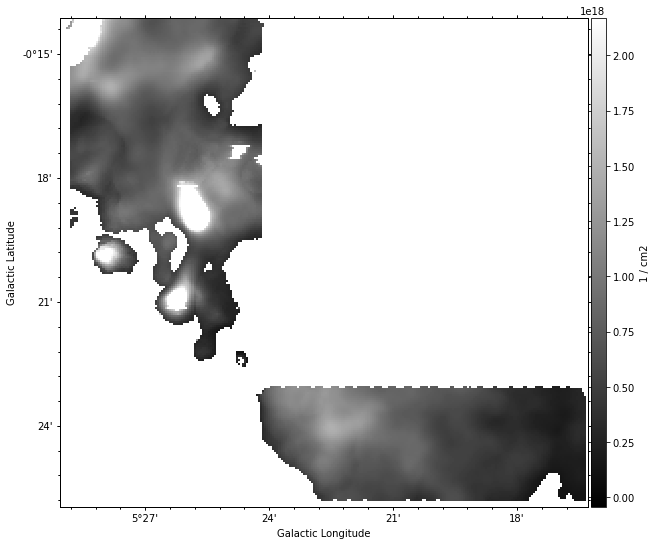

In [99]:
coor = (save.reproject(pro3.header)*op)
coor.quicklook()
coor.FITSFigure.colorbar.set_axis_label_text(coor.unit)

In [100]:
coor.nansum()

<Projection 1.39300262e+22 1 / cm2>

In [101]:
save.nansum()

<Projection 1.18847412e+22 1 / cm2>

INFO: Auto-setting vmin to  1.132e-05 [aplpy.core]
INFO: Auto-setting vmax to  1.436e-04 [aplpy.core]


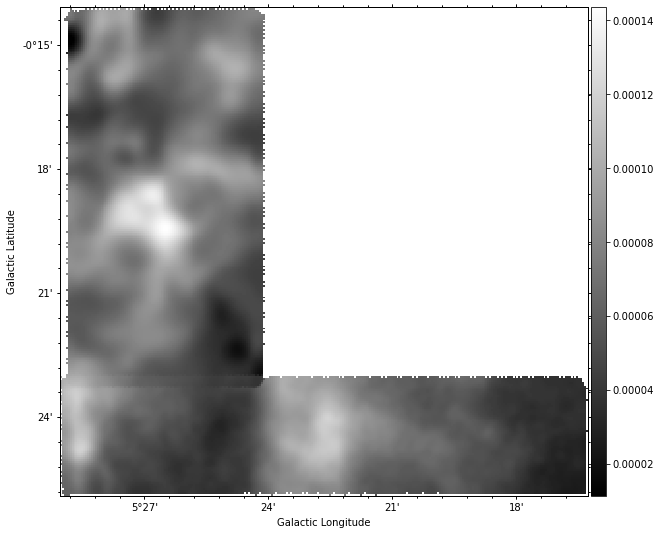

In [102]:
pix_area = save.wcs.celestial.proj_plane_pixel_area()
d = 7 * u.kpc
pix_area_cm = (pix_area * d**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)
mass_conv = 2.8 * u.Da
mass_map = (save * pix_area_cm * mass_conv).to(u.M_sun)
mass_map.quicklook()

INFO: Auto-setting vmin to -9.776e-06 [aplpy.core]
INFO: Auto-setting vmax to  4.463e-04 [aplpy.core]


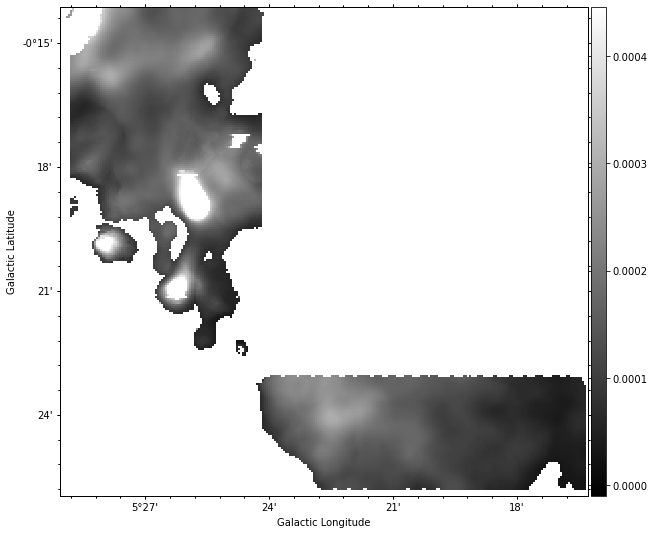

In [103]:
mass_map = (coor * pix_area_cm * mass_conv).to(u.M_sun)
mass_map.quicklook()

In [104]:
mass_map.nansum()

<Projection 2.8133398 solMass>

In [105]:
np.nanmean(ratio_29_17_A_mean)**(-1)

<Projection 21.02641>

In [106]:
np.nanmin(ratio_29_17_A_mean)**(-1)

<Projection 37.16277902>

In [107]:
1/30

0.03333333333333333

In [108]:
np.nanmax(ratio_29_17_A_mean)**(-1)

<Projection 11.57277481>

In [109]:
np.nanmean(ratio_29_17_B_mean)**(-1)

<Projection 14.61728026>

In [110]:
#def funct(tau, A): # = R
    #A = 30
 #   return (1-np.e**(-tau))/(1-np.e**(-tau/A))

In [111]:
lis = np.linspace(0.1, 1.5, num=50)
r = funct(lis, 30)
r


array([28.59638231, 28.21185952, 27.83439698, 27.46384856, 27.10007136,
       26.74292561, 26.39227464, 26.04798481, 25.70992538, 25.37796854,
       25.05198923, 24.73186518, 24.41747678, 24.10870705, 23.80544157,
       23.50756841, 23.2149781 , 22.92756355, 22.64522   , 22.36784498,
       22.09533826, 21.82760175, 21.56453954, 21.30605775, 21.05206457,
       20.80247017, 20.55718664, 20.31612798, 20.07921007, 19.84635056,
       19.6174689 , 19.39248626, 19.17132551, 18.95391117, 18.74016938,
       18.53002785, 18.32341586, 18.12026416, 17.92050502, 17.72407213,
       17.53090059, 17.34092688, 17.15408884, 16.97032562, 16.78957764,
       16.61178662, 16.43689548, 16.26484835, 16.09559055, 15.92906854])

In [112]:
import sys
sys.executable

'/orange/adamginsburg/miniconda3/envs/python39/bin/python'

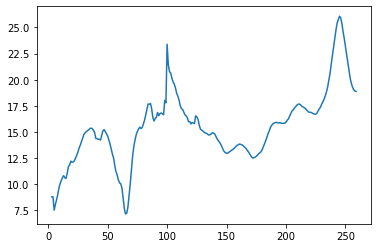

In [113]:
plt.plot(ratio_29_17_B_mean**(-1))

In [114]:
tau = 1.5#np.ones(len(ratio_29_17_A_mean))#1.5
R = 20#ratio_29_17_A_mean**(-1) #20
step = 0.01
tol = 0.1
A = 30
i = 0


def find_tau(tau, R, A, tol, step): # Root finding
    i=0
    while (np.less(funct(tau, A), R-tol) or np.greater(funct(tau, A), R+tol)) and i < 500:
        i+=1
        if funct(tau, A) > R:
            tau = tau + step
        elif funct(tau, A) < R:
            tau = tau - step
    print(i)  
    return tau

In [115]:
np.nan_to_num(ratio_29_17_B**(-1))

<Projection [[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]]>

In [116]:
taus = np.ones(np.nan_to_num(ratio_29_17_B**(-1)).shape)
rat = np.nan_to_num(ratio_29_17_B**(-1))

for t in range(len(taus)):
    taus[t] = (fsolve(F, taus[t], rat[t]))*(rat[t] != 0)
    
taus[taus>2] = 0
pro = Projection(value=taus, wcs=ratio_29_17_B.wcs)
#taus[taus<0] = 0

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


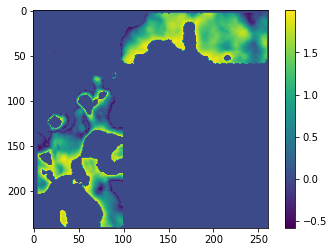

In [117]:

#taus[55, 97] = 0#np.nan
#taus[1, 98] = 0


plt.imshow(taus[:]) # 55, 97
plt.colorbar()

INFO: Auto-setting vmin to -6.953e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.249e+00 [aplpy.core]


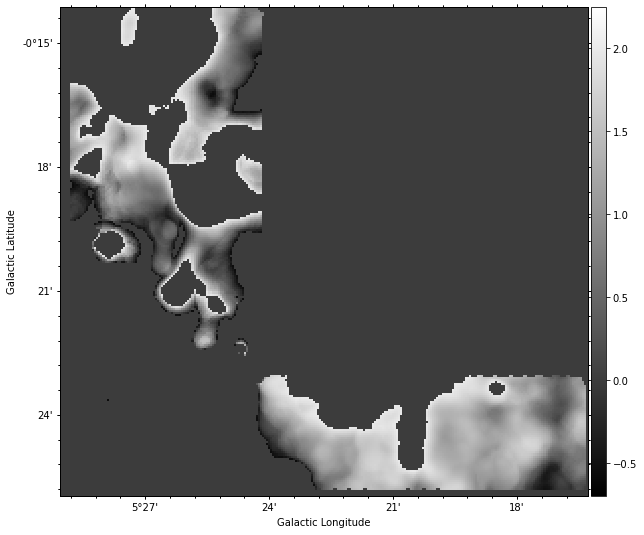

In [118]:
pro.quicklook()

In [119]:
taus_1218 = np.ones(np.nan_to_num(ratio_31_17_B**(-1)).shape)
rat_1218 = np.nan_to_num(ratio_31_17_B**(-1))

for t in range(len(taus_1218)):
    taus_1218[t] = (fsolve(F_1218, taus_1218[t], rat_1218[t]))*(rat_1218[t] != 0)
    
#taus_1218[taus_1218>2] = 0
#taus_1218[taus_1218<0] = 0

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: overflow encountered in power
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/scratch/local/46264603/ipykernel_102095/447486617.py:3: RuntimeWarning: invalid value encountered in divide
  return (1-np.e**(-tau))/(1-np.e**(-tau/A))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [120]:
taus_1218[taus_1218>5] = 0
#taus_1218[taus_1218<0] = 0
#plt.imshow(taus_1218)
#plt.colorbar()
pro2 = Projection(value=taus_1218, wcs=ratio_31_17_B.wcs)

INFO: Auto-setting vmin to -1.728e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.056e+00 [aplpy.core]


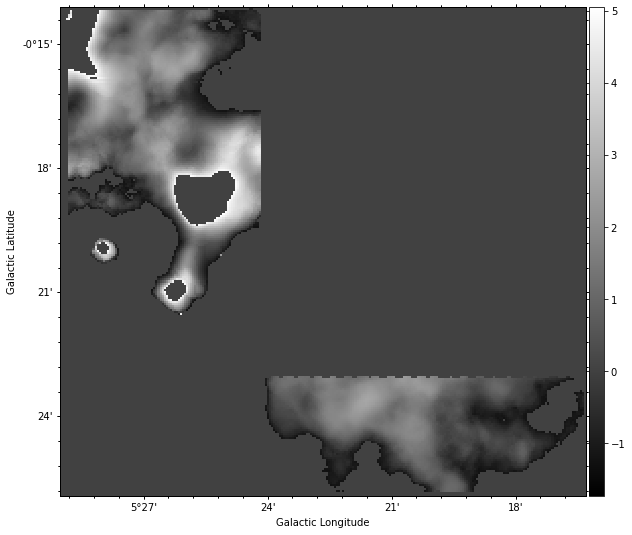

In [121]:
pro2.quicklook()

In [122]:
from astropy import units as u
from astropy import constants as const
import numpy as np

In [123]:
def planck(T, nu):
    one = 2*const.h*nu**3 / const.c**2
    two = np.exp(const.h * nu / (const.k_B * T)) - 1
    return one/two

In [124]:
# Assume that the excitation temperature is the gas temperature?
Tex = 60 * u.K
Tbg = 2.725 * u.K


In [125]:
# 12CO
Eu_12 = 16.59608 * u.K
freq_12 = 230.5380000 * u.GHz
B0 = 57635.968*u.MHz
Q_rot_12 = const.k_B * Tex / (const.h * B0) + 1./3.

In [126]:
# 13CO
Eu_13 = 15.86618 * u.K
freq_13 = 220.39867650 * u.GHz
B0 = 55101.011 * u.MHz
Q_rot_13 = const.k_B * Tex / (const.h * B0) + 1./3.

In [127]:
# C18O
Eu_18 = 15.80580 * u.K
freq_18 = 219.56035410 * u.GHz
B0 = 54891.420 * u.MHz
Q_rot_18 = const.k_B * Tex / (const.h * B0) + 1./3.

In [128]:
N = (3*const.h) / (8 * np.pi * )

SyntaxError: invalid syntax (1906786166.py, line 1)